# DeFi Anti-Fraud

### FCS, 2023

#### Выполнили: Денисов Степан, Карлов Владимир 

***Description:***   

В данном проекте мы попытаемся классифицировать вредоносные смарт-контракты используя его байткод.
Стоить заметить, что задача будет предсказать именно метки 1 и 0, а не просто получить скоры :)

Проект будет состоять из двух частей:
1) ML часть 
2) Инфраструктурная часть

Давайте начнем с ML части и разберемся с моделью.

In [1]:
import pandas as pd
from collections import Counter
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'


SEED = 42
set_random_seed(SEED)

In [2]:
data = pd.read_parquet('Data/malicious_contract_training_dataset_final.parquet', engine='fastparquet')

In [3]:
data.head(3)

contract_address contract_name  \
82965  0x04ae3226c80e8c04d35e6e56089345bdd06da6de                 
82966  0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11                 
82967  0x79dbe9bbde91a35fa8148a14084979a531fe57ea                 

      contract_etherscan_label             contract_tag  \
82965                           Multichain Exploiter 10   
82966                                                     
82967                                                     

                                 contract_creator  \
82965  0x98f5b0a99f258a09403d965647ee9d53677914af   
82966  0x07e02088d68229300ae503395c6536f09179dc3e   
82967  0x11112f684cb88d43ca0e132e585e882606063fbe   

                                    contract_creation_tx  \
82965  0xe962b06db95db1dedb8b1664bf93bb8816c0cfbd1876...   
82966  0xae03b08f220e5d7750e97e67ea85ac6e69649f6fd6d8...   
82967  0x07766fa0cb09dc5221763049c4a2fbbf3556c8660490...   

                                       creation_bytecode  \
82965  0x6080604052600180546001600160a01b03191673c02a...   
82966  0x60a0604052600180553373ffffffffffffffffffffff...   
82967  0x6080604052600080546001600160a01b031990811673...   

                                      decompiled_opcodes  malicious  \
82965  PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 S...       True   
82966  PUSH1 0xa0 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 S...       True   
82967  PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...       True   

                   contract_creator_tag                       source notes  \
82965                                    Luabase ethereum.tags table         
82966                  xToken Exploiter  Luabase ethereum.tags table         
82967  Malicious Actor (Exploit Abuser)  Luabase ethereum.tags table         

      contract_creator_etherscan_label     block  
82965                          exploit  14041572  
82966                            heist  12419856  
82967                            heist  13693565

In [4]:
data.shape

(50927, 14)

In [5]:
data.decompiled_opcodes.iloc[0]

'PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 SLOAD PUSH1 0x01 PUSH1 0x01 PUSH1 0xa0 SHL SUB NOT AND PUSH20 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 OR SWAP1 SSTORE CALLVALUE DUP1 ISZERO PUSH2 0x0036 JUMPI PUSH1 0x00 DUP1 REVERT JUMPDEST POP PUSH2 0x0040 CALLER PUSH2 0x0045 JUMP JUMPDEST PUSH2 0x0095 JUMP JUMPDEST PUSH1 0x00 DUP1 SLOAD PUSH1 0x01 PUSH1 0x01 PUSH1 0xa0 SHL SUB DUP4 DUP2 AND PUSH1 0x01 PUSH1 0x01 PUSH1 0xa0 SHL SUB NOT DUP4 AND DUP2 OR DUP5 SSTORE PUSH1 0x40 MLOAD SWAP2 SWAP1 SWAP3 AND SWAP3 DUP4 SWAP2 PUSH32 0x8be0079c531659141344cd1fd0a4f28419497f9722a3daafe3b4186f6b6457e0 SWAP2 SWAP1 LOG3 POP POP JUMP JUMPDEST PUSH2 0x0605 DUP1 PUSH2 0x00a4 PUSH1 0x00 CODECOPY PUSH1 0x00 RETURN UNKNOWN_0xfe PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x04 CALLDATASIZE LT PUSH2 0x008a JUMPI PUSH1 0x00 CALLDATALOAD PUSH1 0xe0 SHR DUP1 PUSH4 0x9dc29fac GT PUSH2 0x0059 JUMPI DUP1 PUSH4 0x9dc29fac EQ PUSH2 0x0128 JUMPI DUP1 PUSH4 0xbebbf4d0 EQ PUSH2 0x015b JUMPI DUP1 PUSH4 0xd505accf EQ PUSH2 0x0

In [6]:
data = data[["decompiled_opcodes", "malicious"]]
data["malicious"] = data["malicious"].astype(int)

Ага, что мы имеем? 

Есть колонка 'decompiled_opcodes' - это и будет нашими фичами

Malicious - наш таргет

In [7]:
data.malicious.value_counts() / len(data)

malicious
0    0.997506
1    0.002494
Name: count, dtype: float64

Как видно, у нас имеется значительный дисбаланс классов, что на самом деле и соответствует реальности. 

Как ни крути, не все юзеры блокчейна занимаются непотребствами.

## Предобработка данных (1 балл)

Давайте предобработаем данные, важно понимать что в байткоде будут иметься сигнатуры и адреса других контрактов

Может ли это быть полезно?

Это будет зависеть от вас

В данной секции от вас ожидается предобработка данных

Визуализация и анализ природы данных - необязательны, но желательны, если найдете что-то интересное - мы это вам зачтем в виде бонуса +1 балл :) 

### Train / test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# ориентируюсь на то, что разбиение менять нельзя

X = data.drop(columns='malicious')
y = data.malicious.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=SEED, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.30, random_state=SEED, stratify=y_test)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(ngram_range=(1, 3))
vectorizer = TfidfVectorizer()

In [11]:
X_train = vectorizer.fit_transform(X_train.decompiled_opcodes)

In [12]:
X_val = vectorizer.transform(X_val.decompiled_opcodes)
X_test = vectorizer.transform(X_test.decompiled_opcodes)

In [13]:
X_train.shape

(30556, 392530)

## Модель (5 баллов)

Итак перед вами стоит задача классифицировать смарт-контракты.

Представьте что вы глава проекта из https://cyvers.ai/ 

Вы разрабатываете софт для фондов, которые вкладывает деньги в различные DeFi протоколы и им важно своевременно выводить деньги.

Перед вами стоит задача разработать предиктивный софт по DeFi безопасности, возникает несколько вопросов:

1) Выбор модели на ваше усмотрение, помните что потом эту модель вам нужно будет использовать в инфраструктурном коде
    * бейзлайн -- выделить признаки каким-либо статистическим способом из текста (BoW, TF-IDF, здесь мы выбрали самое сложное из простого)
    * попробовать на этом линейные модели (LogReg, SVM), скорее всего понять, что они будут работать плохо
    * попробовать бустинги (+ потюнить параметры)
    * если не хватит -- поменять стат. методы для фичей на эмбеддинги CodeBert
    * если и этого не хватит -- расчехлить A100 и дообучить CodeBert на классификацию с warmup'ом    

2) Помните, что модель нужна для своевременного реагирования на угрозу, важна ли здесь скорость инференса?
    * Скорее склоняюсь к тому, что скорость инференса довольно важна, поскольку нужно будет за адекватное время предпринять необходимые меры, чтобы остановить злоумышленников
3) Является ли более предпочтительной интепретируемость, либо более эффективная модель, но блек бокс?
    * Мне кажется, тут 
4) Как вы думаете, что важнее в нашей задаче precision или recall?
    * В нашей задаче, на мой взгляд, довольно явно полнота является более важной, чем точность, поскольку для нас гораздо критичнее предотвартить всю реальную перспективу фрода, заблокировать при этом какую-то часть безопасных операций, нежели чем заблокировать меньше и допустить ситуацию, когда мошенники украдут много денег.
5) Как именно вы будете работать с дисбалансом классом, а именно какую метрику выберете?
    * Для работы с дизбалансом первой идеей будет использование весов для классов в соответствии с их встречаемостью, после этого можно попровать разные стратегии upsempling'a и downsampling'a
    * В качестве метрики стоит использовать F-score, либо AUC-PR, поскольку они наиболее усточивы к такому огромному дисбалансу классов

Все это решать вам!

Ваши рассуждения и комментарии в ноутбуке - также влияют на оценку, поэтому не стесняйтесь рассуждать, важна ваша мысль

### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(penalty='l2', random_state=SEED, class_weight='balanced').fit(X_train, y_train)

In [63]:
y_pred = log_reg_clf.predict_proba(X_test)
y_pred_c = log_reg_clf.predict(X_test)

In [64]:
y_pred_c.sum()

137

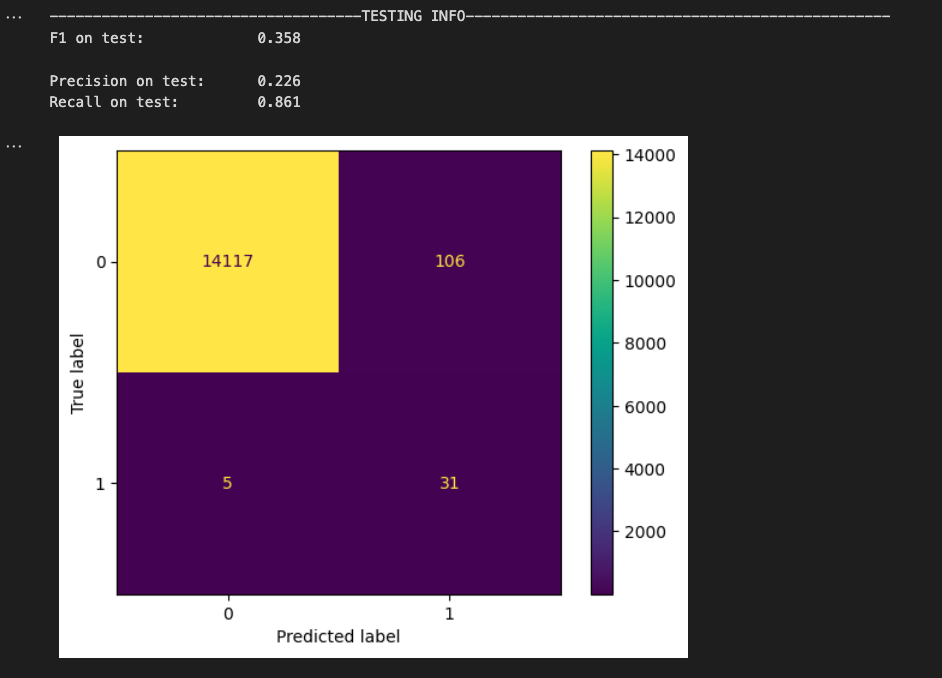

### Catboost classifier

In [18]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier(random_seed=SEED, eval_metric='F1', task_type='CPU')

In [19]:
cb_clf.fit(X_train, y_train, verbose=True, eval_set=(X_val, y_val), use_best_model=True)

Learning rate set to 0.073744
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.01s	remaining: 16m 46s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.76s	remaining: 14m 40s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.52s	remaining: 13m 57s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.29s	remaining: 13m 38s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.04s	remaining: 13m 23s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 4.8s	remaining: 13m 14s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 5.54s	remaining: 13m 5s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.29s	remaining: 13m
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.04s	remaining: 12m 55s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 7.79s	remaining: 12m 51s
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.54s	remaining: 12m 47s
11:	lea

In [23]:
cb_clf.save_model(
    'Model/catboost_clf_checkpoint.cbm',
    format="cbm",
    export_parameters=None,
    pool=None
)

In [26]:
y_pred = cb_clf.predict_proba(X_test)
y_pred_c = cb_clf.predict(X_test)

## Анализ результатов и ваши метрики (1 балл)

### Посмотрим на метрики

In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from functools import partial

f1_score_weighted = partial(f1_score, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

def compute_metrics(y_test, y_pred, y_pred_c):
    """
    y_pred = ваши скоры на тесте
    y_pred_c = метки класса на тесте
    y_test = метки на тесте
    """
    print('------------------------------------TESTING INFO-------------------------------------------------')
    
    print(f'F1 on test: \t\t{f1_score_weighted(y_test, y_pred_c):.3f}', end='\n\n')
    print(f'Precision on test: \t{precision_score(y_test, y_pred_c):.3f}')
    print(f'Recall on test: \t{recall_score(y_test, y_pred_c):.3f}')

    cm = confusion_matrix(y_test, y_pred_c, labels=[0,1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[0,1]
    )
    disp.plot()
    plt.show()

------------------------------------TESTING INFO-------------------------------------------------
F1 on test: 		0.604

Precision on test: 	0.941
Recall on test: 	0.444


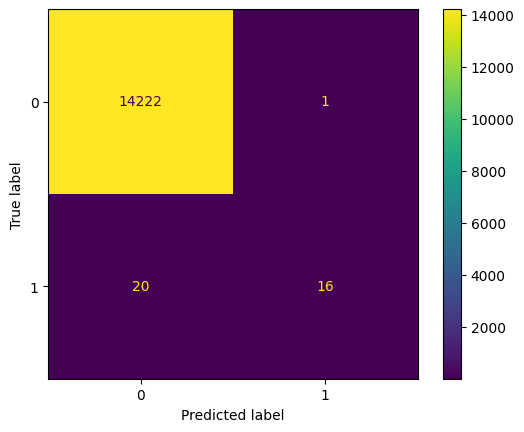

In [28]:
compute_metrics(y_test, y_pred, y_pred_c)

### Посмотрим на распределение скоров модели на тесте

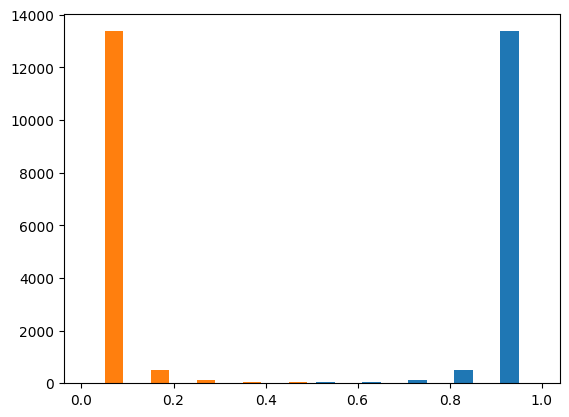

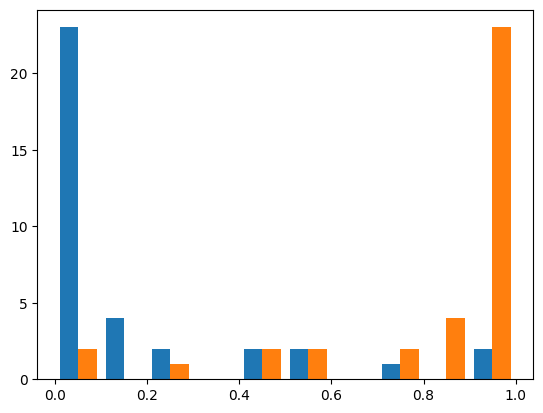

In [85]:
plt.hist(y_pred[y_test==0])
plt.show()
plt.hist(y_pred[y_test==1])
plt.show()

### Интерпретируемость модели

In [25]:
# Вжух ваша интерпретация если она есть как вы думаете логичны ли выводы?

### Тесты на реальных данных

Test for https://etherscan.io/address/0xcff07c4e6aa9e2fec04daaf5f41d1b10f3adadf4

This is a https://rekt.news/teamfinance-rekt/ malicious contract

In [ ]:
from test_data import team_finance_exploit

In [26]:
# Вжух посмотрим на результаты?

## Сохранение модели

In [28]:
# Сохраняем в директорию Model/ и идем в инфраструктурную часть 